In [ ]:
import os
import numpy as np
import cv2
import natsort
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from numpy import r_
import time
from time import time
import scipy.io
from PIL import Image

from RefinedTramsmission import Refinedtransmission
from getAtomsphericLight import getAtomsphericLight
from getGbDarkChannel import getDarkChannel
from getTM import getTransmission
from sceneRadiance import sceneRadianceRGB

In [ ]:
class Channel_value:
    val = -1.0
    intensity = -1.0


def find_intensity_of_atmospheric_light(img, gray):
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num
    dark_channel = find_dark_channel(img)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:
                if t.val < val or (t.val == val and t.intensity < intensity):
                    t.val = val
                    t.intensity = intensity
                    break

    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t

    return max_channel.intensity


def find_dark_channel(img):
  if (len(img.shape)>2):
    return np.unravel_index(np.argmin(img), img.shape)[2]
  if (len(img.shape)<3):
    return np.unravel_index(np.argmin(img), img.shape)[1]


def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))


def dehaze(img, light_intensity, windowSize, t0, w):
    size = (img.shape[0], img.shape[1])

    outimg = np.zeros(img.shape, img.dtype)
    #print(len(outimg.shape))

    for y in range(size[0]):
        for x in range(size[1]):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y+(windowSize//2), size[0])

            sliceimg = img[y_low:y_high, x_low:x_high]

            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)

            if (len(outimg.shape)>2):
              outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
              outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
              outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))

            if (len(outimg.shape)<3):
              outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
              outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))

    return outimg

Text(0.5, 1.0, 'HW_SPI')

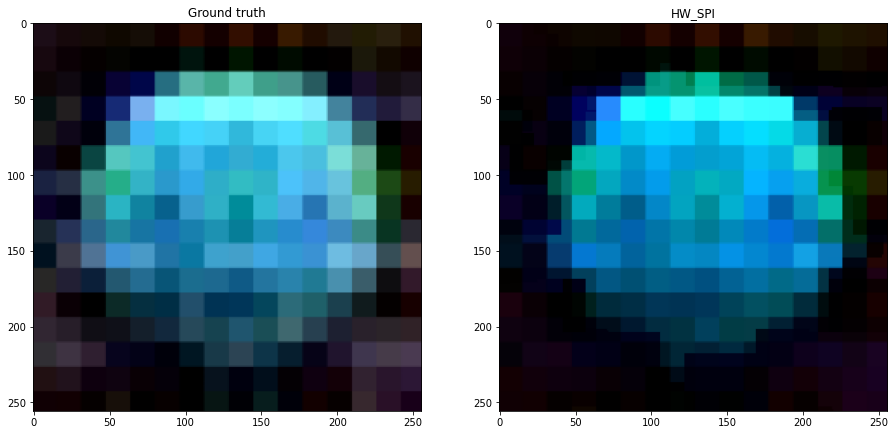

In [ ]:
img1 = cv2.imread("/content/test_art_16.png")
img1=cv2.resize(img1,(256,256))
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
light_intensity_1 = find_intensity_of_atmospheric_light(img1, gray1)
w = 0.95
t0 = 0.55

outimg_1 = dehaze(img1, light_intensity_1, 20, t0, w)

plt.figure(figsize=(32,32))
plt.subplot(141)
plt.imshow(img1[:,:,::-1]);
plt.title("Ground truth")

plt.subplot(142)
plt.imshow(outimg_1[:,:,::-1]);
plt.title("HW_SPI")

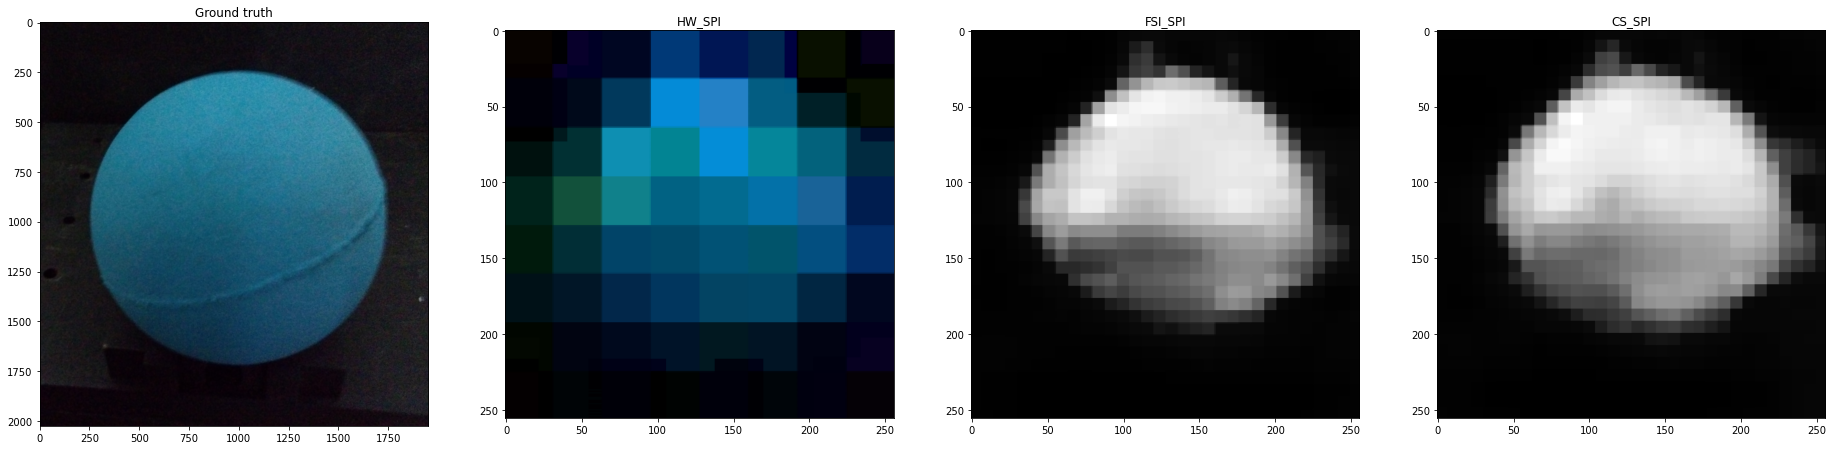

In [ ]:
img1 = cv2.imread("/content/HW_color.png")
img2 = cv2.imread("/content/Fsi_color2.png")
img3 = cv2.imread("/content/wh_color2.png")

img1=cv2.resize(img1,(256,256))
img2=cv2.resize(img2,(256,256))
img3=cv2.resize(img3,(256,256))

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

w = 0.95
t0 = 0.55

light_intensity_1 = find_intensity_of_atmospheric_light(img1, gray1)
light_intensity_2 = find_intensity_of_atmospheric_light(img2, gray2)
light_intensity_3 = find_intensity_of_atmospheric_light(img3, gray3)


outimg_1 = dehaze(img1, light_intensity_1, 20, t0, w)
outimg_2 = dehaze(img2, light_intensity_2, 50, t0, w)
outimg_3 = dehaze(img3, light_intensity_3, 20, t0, w)

outimg_4=cv2.cvtColor(outimg_2,cv2.COLOR_BGR2GRAY)

img3 = cv2.imread("/content/azul.jpg")

plt.figure(figsize=(32,32))
plt.subplot(141)
plt.imshow(img3[:,:,::-1]);
plt.title("Ground truth")

plt.subplot(142)
plt.imshow(outimg_1[:,:,::-1]);
plt.title("HW_SPI")

plt.subplot(143)
plt.imshow(outimg_2[:,:,::-1]);
plt.title("FSI_SPI");

plt.subplot(144)
plt.imshow(outimg_3[:,:,::-1]);
plt.title("CS_SPI");

plt.imsave('eccv16.png', outimg_3)

In [ ]:
from base_color import *
#import eccv16
#import siggraph17
import util
import torch
import torch.nn as nn

In [ ]:
class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

def eccv16(pretrained=True):
	model = ECCVGenerator()
	if(pretrained):
		import torch.utils.model_zoo as model_zoo
		model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',map_location='cpu',check_hash=True))
	return model


In [ ]:
colorizer_eccv16 = eccv16(pretrained=True).eval()
img = outimg_4

Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth" to /root/.cache/torch/hub/checkpoints/colorization_release_v2-9b330a0b.pth


  0%|          | 0.00/123M [00:00<?, ?B/s]

In [ ]:
img.shape

(316, 318)

In [ ]:
img2 = cv2.cvtColor(outimg_4,cv2.COLOR_GRAY2BGR)

(-0.5, 255.5, 255.5, -0.5)

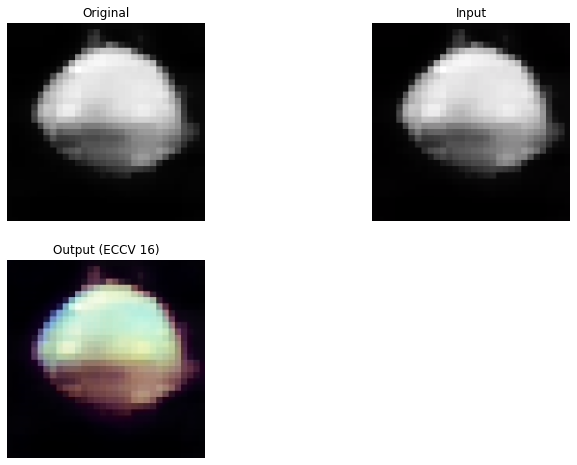

In [ ]:
#img2 = util.load_img('/content/test18.png')
(tens_l_orig, tens_l_rs) = util.preprocess_img(img2, HW=(256,256))
#if(opt.use_gpu):
#	tens_l_rs = tens_l_rs.cuda()

img_bw = util.postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = util.postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(img2)
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_bw)
plt.title('Input')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV 16)')
plt.axis('off')